# ASSIGNMENT 20
<br>
<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [32]:
import pandas as pd
df=pd.read_csv('nlp_features_train.csv')

### PREPAIRING DATA FOR TF-IDF

In [33]:
df=df[:50000]

In [34]:
df=df.dropna()

In [5]:
tfidf_vect = TfidfVectorizer(max_features=4000)

In [9]:
df_train=df[:35000]
df_test=df[:15000]

In [12]:
def trans(df):
    tfidf_vect.fit(pd.concat((df['question1'],df['question2'])))
    trainq1_trans = tfidf_vect.transform(df['question1'].values)
    trainq2_trans = tfidf_vect.transform(df['question2'].values)
    x=df
    y=df['is_duplicate']
    x=x.drop(['qid1','qid2','id','question1','question2','is_duplicate'],axis=1)
    ind=np.arange(1,4001)
    x_index=[]
    y_index=[]
    for i in ind:
        x_index.append('x'+str(i))
        y_index.append('y'+str(i))
    count_vect_df1 = pd.DataFrame(trainq1_trans.todense(), columns=x_index)
    count_vect_df2 = pd.DataFrame(trainq2_trans.todense(), columns=y_index)
    result = pd.concat([x,count_vect_df1], axis=1, sort=False)
    result = pd.concat([result,count_vect_df2], axis=1, sort=False)
    result.to_csv('tfidf_train.csv')
    y.to_csv('tfidf_target_train.csv')

In [13]:
trans(df_train)

In [16]:
def trans_test(df):
    tfidf_vect.fit_transform(pd.concat((df['question1'],df['question2'])))
    trainq1_trans = tfidf_vect.transform(df['question1'].values)
    trainq2_trans = tfidf_vect.transform(df['question2'].values)
    x=df
    y=df['is_duplicate']
    x=x.drop(['qid1','qid2','id','question1','question2','is_duplicate'],axis=1)
    ind=np.arange(1,4001)
    x_index=[]
    y_index=[]
    for i in ind:
        x_index.append('x'+str(i))
        y_index.append('y'+str(i))
    count_vect_df1 = pd.DataFrame(trainq1_trans.todense(), columns=x_index)
    count_vect_df2 = pd.DataFrame(trainq2_trans.todense(), columns=y_index)
    result = pd.concat([x,count_vect_df1], axis=1, sort=False)
    result = pd.concat([result,count_vect_df2], axis=1, sort=False)
    result.to_csv('tfidf_test.csv')
    y.to_csv('tfidf_target_test.csv')

In [ ]:
trans_test(df_test)

In [2]:
X_train=pd.read_csv('tfidf_train.csv')

In [3]:
X_test=pd.read_csv('tfidf_test.csv')

In [4]:
X_train=X_train.drop(['Unnamed: 0'],axis=1)
X_test=X_test.drop(['Unnamed: 0'],axis=1)

In [5]:
X_train=X_train.dropna()
X_test=X_test.dropna()
X_train.shape,X_test.shape

((34996, 8015), (14998, 8015))

In [6]:
y_train=pd.read_csv('tfidf_target_train.csv')
y_test=pd.read_csv('tfidf_target_test.csv')

In [7]:
y_train=y_train.drop(['0'],axis=1)
y_test=y_test.drop(['0'],axis=1)

In [8]:
y_train=y_train.dropna()
y_test=y_test.dropna()

In [9]:
y_train=y_train[:-3]
y_test=y_test[:-1]

In [10]:
y_train.shape,y_test.shape

((34996, 1), (14998, 1))

In [11]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (34996, 8015)
Number of data points in test data : (14998, 8015)


In [12]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.0 Class 1:  0.0
---------- Distribution of output variable in train data ----------
Class 0:  0.0 Class 1:  0.0


In [13]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### MODELING 


<h2> Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8940929603220081


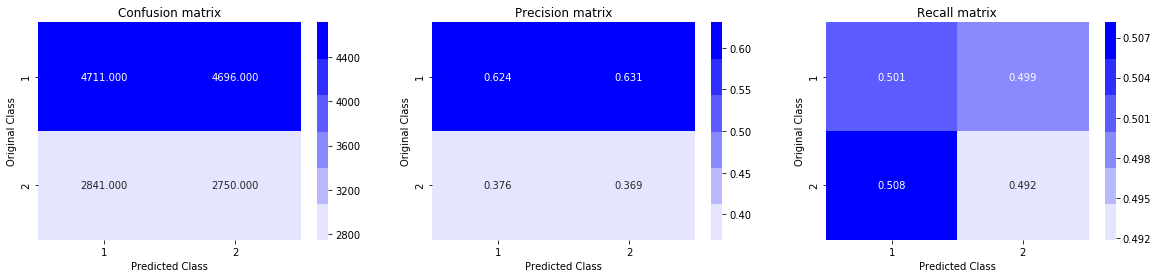

In [14]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2>Logistic Regression with hyperparameter tuning </h2>

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  1e-05 The log loss is: 0.6604203098834983


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.0001 The log loss is: 0.660411310494652


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.001 The log loss is: 0.6603882136027764


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.01 The log loss is: 0.660408356838762


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.1 The log loss is: 0.6604139305650183


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  1 The log loss is: 0.6604086794208951


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  10 The log loss is: 0.6604093256381702


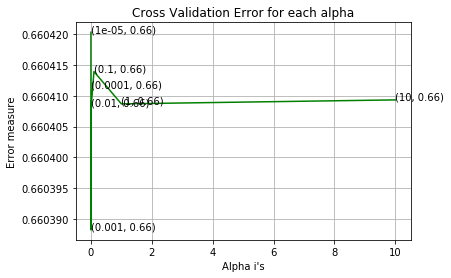

In [15]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
from sklearn.linear_model import SGDClassifier


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()




C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of best alpha =  0.001 The train log loss is: 0.6603501371403995
For values of best alpha =  0.001 The test log loss is: 0.6603882136027764
Total number of data points : 14998


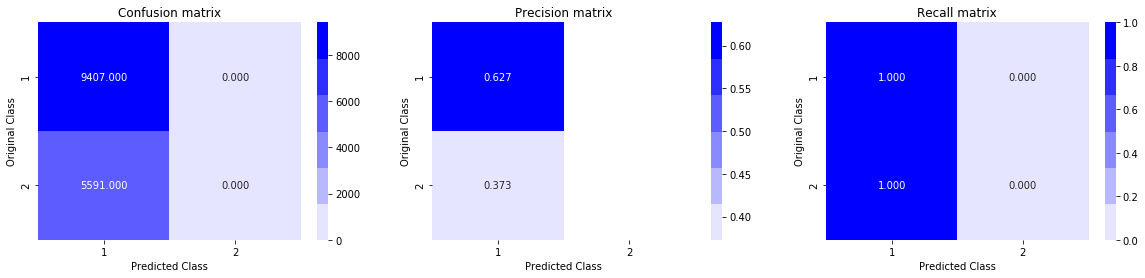

In [16]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Linear SVM with hyperparameter tuning </h2>

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  1e-05 The log loss is: 0.6604203098834983


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.0001 The log loss is: 0.660411310494652


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.001 The log loss is: 0.6603882136027764


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.01 The log loss is: 0.660408356838762


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  0.1 The log loss is: 0.6604139305650183


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  1 The log loss is: 0.6604086794208951


C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of alpha =  10 The log loss is: 0.6604093256381702


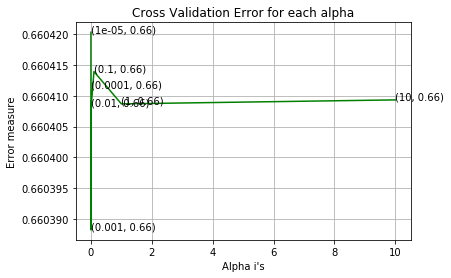

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For values of best alpha =  0.001 The train log loss is: 0.6603501371403995
For values of best alpha =  0.001 The test log loss is: 0.6603882136027764
Total number of data points : 14998


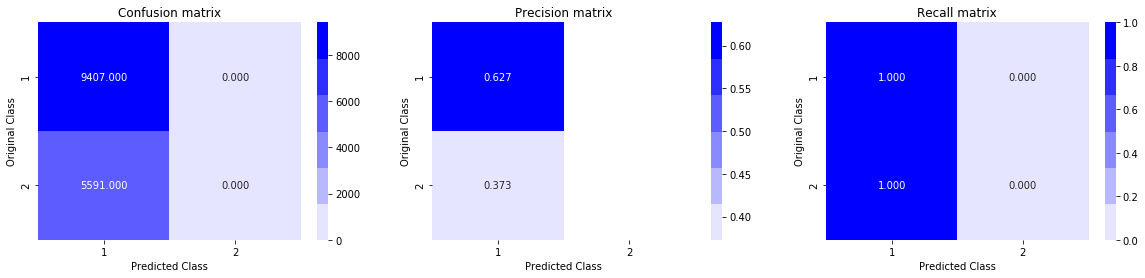

In [17]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Hyperparameter tunning, XgBoost using RandomSearch to reduce the log-loss.

In [17]:
def tfidfw2v(df,name):
    df['question1'] = df['question1'].apply(lambda x: str(x))
    df['question2'] = df['question2'].apply(lambda x: str(x))
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import CountVectorizer
    # merge texts
    questions = list(df['question1']) + list(df['question2'])

    tfidf = TfidfVectorizer(lowercase=False, )
    tfidf.fit_transform(questions)

    # dict key:word and value:tf-idf score
    word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
    # en_vectors_web_lg, which includes over 1 million unique vectors.
    nlp = spacy.load("en_core_web_sm")

    vecs1 = []
    # https://github.com/noamraph/tqdm
    # tqdm is used to print the progress bar
    for qu1 in tqdm(list(df['question1'])):
        doc1 = nlp(qu1) 
        # 384 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)

    df['q1_feats_m'] = list(vecs1)
    vecs2 = []
    for qu2 in tqdm(list(df['question2'])):
        doc2 = nlp(qu2) 
        mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
        for word2 in doc2:
            # word2vec
            vec2 = word2.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word2)]
            except:
                #print word
                idf = 0
            # compute final vec
            mean_vec2 += vec2 * idf
        mean_vec2 = mean_vec2.mean(axis=0)
        vecs2.append(mean_vec2)
    df['q2_feats_m'] = list(vecs2)
    #prepro_features_train.csv (Simple Preprocessing Feartures)
    #nlp_features_train.csv (NLP Features)
    if os.path.isfile('nlp_features_train.csv'):
        dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    else:
        print("download nlp_features_train.csv from drive or run previous notebook")

    if os.path.isfile('df_fe_without_preprocessing_train.csv'):
        dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    else:
        print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")
    df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
    df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
    df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
    df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
    df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)
    # storing the final features to csv file
    
    if not os.path.isfile(name):
        df3_q1['id']=df1['id']
        df3_q2['id']=df1['id']
        df1  = df1.merge(df2, on='id',how='left')
        df2  = df3_q1.merge(df3_q2, on='id',how='left')
        result  = df1.merge(df2, on='id',how='left')
        result.to_csv(name)

In [18]:
df = pd.read_csv("train.csv")
df=df[:50000]
df_train=df[:35000]
df_test=df[35000:]
name_tr='final_features_tr.csv'
name_test='final_features_test.csv'

In [23]:
tfidfw2v(df_train,name_tr)


  2%|█▍                                                                            | 649/35000 [00:15<13:48, 41.46it/s]


  4%|███                                                                          | 1369/35000 [00:31<12:45, 43.92it/s]


  6%|████▌                                                                        | 2088/35000 [00:46<10:55, 50.19it/s]


  8%|██████▏                                                                      | 2839/35000 [01:01<11:20, 47.29it/s]


 10%|███████▉                                                                     | 3585/35000 [01:16<11:23, 45.97it/s]


 12%|█████████▍                                                                   | 4311/35000 [01:31<10:49, 47.24it/s]


 14%|███████████                                                                  | 5008/35000 [01:46<10:30, 47.60it/s]


 16%|████████████▌                                                                | 5717/35000 [02:01<10:25, 46.81it/s]


 18%|██████████████▏                                                              | 6440/35000 [02:17<11:13, 42.44it/s]


 20%|███████████████▌                                                             | 7081/35000 [02:33<12:39, 36.76it/s]


 22%|█████████████████▎                                                           | 7843/35000 [02:49<09:34, 47.30it/s]


 24%|██████████████████▊                                                          | 8557/35000 [03:05<10:43, 41.06it/s]


 26%|████████████████████▍                                                        | 9267/35000 [03:21<08:26, 50.81it/s]


 29%|█████████████████████▋                                                      | 10006/35000 [03:36<08:35, 48.53it/s]


 31%|███████████████████████▍                                                    | 10772/35000 [03:51<07:33, 53.39it/s]


 33%|█████████████████████████                                                   | 11523/35000 [04:07<07:47, 50.20it/s]


 35%|██████████████████████████▋                                                 | 12274/35000 [04:22<07:47, 48.58it/s]


 37%|████████████████████████████▎                                               | 13022/35000 [04:38<07:40, 47.72it/s]


 39%|█████████████████████████████▊                                              | 13701/35000 [04:54<07:04, 50.22it/s]


 41%|███████████████████████████████▎                                            | 14429/35000 [05:10<07:35, 45.20it/s]


 43%|████████████████████████████████▉                                           | 15151/35000 [05:26<09:13, 35.84it/s]


 45%|██████████████████████████████████▎                                         | 15822/35000 [05:42<06:24, 49.92it/s]


 47%|███████████████████████████████████▉                                        | 16573/35000 [05:57<06:12, 49.45it/s]


 50%|█████████████████████████████████████▋                                      | 17332/35000 [06:13<06:07, 48.13it/s]


 52%|███████████████████████████████████████▏                                    | 18039/35000 [06:29<06:13, 45.41it/s]


 54%|████████████████████████████████████████▋                                   | 18751/35000 [06:44<05:27, 49.67it/s]


 55%|██████████████████████████████████████████▏                                 | 19402/35000 [07:00<05:24, 48.08it/s]


 57%|███████████████████████████████████████████▋                                | 20096/35000 [07:16<06:24, 38.79it/s]


 59%|█████████████████████████████████████████████                               | 20781/35000 [07:32<04:58, 47.67it/s]


 61%|██████████████████████████████████████████████▋                             | 21480/35000 [07:48<06:49, 32.99it/s]


 63%|████████████████████████████████████████████████▏                           | 22191/35000 [08:03<04:15, 50.22it/s]


 65%|█████████████████████████████████████████████████▋                          | 22893/35000 [08:18<04:38, 43.43it/s]


 67%|███████████████████████████████████████████████████▎                        | 23615/35000 [08:33<03:59, 47.53it/s]


 70%|████████████████████████████████████████████████████▊                       | 24336/35000 [08:48<03:31, 50.32it/s]


 72%|██████████████████████████████████████████████████████▍                     | 25066/35000 [09:03<03:31, 46.98it/s]


 74%|███████████████████████████████████████████████████████▉                    | 25778/35000 [09:18<03:12, 47.87it/s]


 76%|█████████████████████████████████████████████████████████▌                  | 26494/35000 [09:33<03:01, 46.97it/s]


 78%|███████████████████████████████████████████████████████████                 | 27214/35000 [09:48<02:43, 47.51it/s]


 80%|████████████████████████████████████████████████████████████▋               | 27929/35000 [10:03<02:29, 47.23it/s]


 82%|██████████████████████████████████████████████████████████████▏             | 28658/35000 [10:18<02:10, 48.75it/s]


 84%|███████████████████████████████████████████████████████████████▋            | 29337/35000 [10:34<02:36, 36.10it/s]


 86%|█████████████████████████████████████████████████████████████████           | 29960/35000 [10:51<03:15, 25.84it/s]


 88%|██████████████████████████████████████████████████████████████████▌         | 30638/35000 [11:07<01:34, 46.31it/s]


 90%|████████████████████████████████████████████████████████████████████        | 31356/35000 [11:23<01:20, 45.32it/s]


 92%|█████████████████████████████████████████████████████████████████████▋      | 32115/35000 [11:39<00:51, 56.26it/s]


 94%|███████████████████████████████████████████████████████████████████████▎    | 32834/35000 [11:55<01:26, 24.90it/s]


 96%|████████████████████████████████████████████████████████████████████████▋   | 33448/35000 [12:11<00:42, 36.58it/s]


 97%|█████████████████████████████████████████████████████████████████████████▉  | 34076/35000 [12:27<00:23, 40.09it/s]


 99%|███████████████████████████████████████████████████████████████████████████▌| 34774/35000 [12:42<00:04, 45.94it/s]


  1%|▉                                                                             | 444/35000 [00:11<13:23, 43.02it/s]


  3%|██▎                                                                          | 1057/35000 [00:26<12:42, 44.54it/s]


  5%|███▉                                                                         | 1777/35000 [00:42<13:12, 41.92it/s]


  7%|█████▍                                                                       | 2493/35000 [00:58<13:42, 39.53it/s]


  9%|██████▉                                                                      | 3177/35000 [01:14<11:58, 44.27it/s]


 11%|████████▍                                                                    | 3856/35000 [01:31<10:02, 51.68it/s]


 13%|██████████                                                                   | 4586/35000 [01:47<14:39, 34.59it/s]


 15%|███████████▉                                                                 | 5398/35000 [02:02<09:01, 54.67it/s]


 18%|█████████████▋                                                               | 6221/35000 [02:17<08:38, 55.47it/s]


 22%|█████████████████                                                           | 7849/35000 [02:32<03:37, 125.07it/s]


 28%|█████████████████████                                                       | 9686/35000 [02:47<03:16, 128.67it/s]


 33%|████████████████████████▊                                                  | 11555/35000 [03:01<03:00, 129.69it/s]


 38%|████████████████████████████▊                                              | 13422/35000 [03:16<02:42, 132.39it/s]


 44%|████████████████████████████████▋                                          | 15283/35000 [03:30<02:36, 125.71it/s]


 49%|████████████████████████████████████▋                                      | 17148/35000 [03:45<02:16, 130.37it/s]


 54%|████████████████████████████████████████▋                                  | 19014/35000 [03:59<01:59, 134.10it/s]


 60%|████████████████████████████████████████████▋                              | 20868/35000 [04:14<01:48, 130.10it/s]


 65%|████████████████████████████████████████████████▋                          | 22733/35000 [04:28<01:37, 125.24it/s]


 70%|████████████████████████████████████████████████████▋                      | 24586/35000 [04:42<01:24, 123.50it/s]


 76%|████████████████████████████████████████████████████████▋                  | 26445/35000 [04:57<01:05, 129.81it/s]


 81%|████████████████████████████████████████████████████████████▋              | 28312/35000 [05:11<00:51, 129.50it/s]


 86%|████████████████████████████████████████████████████████████████▋          | 30162/35000 [05:26<00:37, 127.91it/s]


 91%|████████████████████████████████████████████████████████████████████▌      | 32010/35000 [05:40<00:23, 128.48it/s]


 97%|████████████████████████████████████████████████████████████████████████▌  | 33868/35000 [05:54<00:08, 129.28it/s]


100%|████████████████████████████████████████████████████████████████████████████| 35000/35000 [06:03<00:00, 96.23it/s]

In [21]:
tfidfw2v(df_test,name_test)


  7%|█████▏                                                                        | 992/15000 [00:15<04:08, 56.36it/s]


 13%|██████████                                                                   | 1958/15000 [00:31<03:28, 62.57it/s]


 20%|███████████████▌                                                             | 3040/15000 [00:46<02:31, 79.06it/s]


 28%|█████████████████████▍                                                       | 4186/15000 [01:01<02:19, 77.75it/s]


 36%|███████████████████████████▍                                                 | 5334/15000 [01:16<02:07, 75.72it/s]


 44%|█████████████████████████████████▋                                           | 6560/15000 [01:31<01:52, 75.08it/s]


 51%|███████████████████████████████████████▏                                     | 7638/15000 [01:46<02:01, 60.81it/s]


 57%|████████████████████████████████████████████▏                                | 8599/15000 [02:01<01:49, 58.62it/s]


 64%|█████████████████████████████████████████████████                            | 9564/15000 [02:17<01:31, 59.26it/s]


 70%|█████████████████████████████████████████████████████▍                      | 10546/15000 [02:32<01:08, 65.18it/s]


 77%|██████████████████████████████████████████████████████████▎                 | 11514/15000 [02:48<00:55, 63.28it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 12466/15000 [03:03<00:37, 68.28it/s]


 90%|████████████████████████████████████████████████████████████████████▊       | 13575/15000 [03:19<00:24, 59.34it/s]


 97%|█████████████████████████████████████████████████████████████████████████▌  | 14525/15000 [03:34<00:07, 64.39it/s]


  3%|██▍                                                                           | 470/15000 [00:07<03:58, 60.90it/s]


  9%|███████▎                                                                     | 1414/15000 [00:23<03:34, 63.33it/s]


 16%|████████████▏                                                                | 2374/15000 [00:38<03:30, 59.91it/s]


 22%|████████████████▉                                                            | 3303/15000 [00:54<03:13, 60.59it/s]


 28%|█████████████████████▊                                                       | 4239/15000 [01:10<02:55, 61.33it/s]


 34%|██████████████████████████▌                                                  | 5175/15000 [01:25<02:40, 61.34it/s]


 41%|███████████████████████████████▍                                             | 6129/15000 [01:41<02:31, 58.54it/s]


 47%|████████████████████████████████████▍                                        | 7097/15000 [01:56<02:01, 64.95it/s]


 53%|█████████████████████████████████████████                                    | 8006/15000 [02:12<02:00, 58.03it/s]


 60%|██████████████████████████████████████████████                               | 8962/15000 [02:28<02:02, 49.47it/s]


 64%|█████████████████████████████████████████████████▍                           | 9638/15000 [02:44<01:51, 48.24it/s]


 69%|████████████████████████████████████████████████████▋                       | 10392/15000 [03:00<01:38, 46.99it/s]


 74%|████████████████████████████████████████████████████████                    | 11074/15000 [03:17<01:45, 37.11it/s]


 78%|███████████████████████████████████████████████████████████▍                | 11721/15000 [03:33<01:19, 41.38it/s]


 83%|███████████████████████████████████████████████████████████████             | 12436/15000 [03:49<01:01, 41.98it/s]


 88%|██████████████████████████████████████████████████████████████████▌         | 13145/15000 [04:05<00:43, 42.40it/s]


 92%|██████████████████████████████████████████████████████████████████████▏     | 13850/15000 [04:20<00:28, 40.67it/s]


 97%|█████████████████████████████████████████████████████████████████████████▌  | 14515/15000 [04:36<00:09, 48.88it/s]


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:47<00:00, 52.19it/s]

In [4]:
X_train=pd.read_csv('final_features_tr.csv')
y_train=X_train['is_duplicate']
X_train=X_train.drop(['Unnamed: 0','id','is_duplicate'],axis=1)

In [5]:
X_test=pd.read_csv('final_features_test.csv')
y_test=X_test['is_duplicate']
X_test=X_test.drop(['Unnamed: 0','id','is_duplicate'],axis=1)

### RANDOM SPLIT

In [6]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (404351, 218)
Number of data points in test data : (404351, 218)


In [7]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307515005527375 Class 1:  0.3692484994472624
---------- Distribution of output variable in train data ----------
Class 0:  0.3692484994472624 Class 1:  0.3692484994472624


<h3> MODELING</h3>

In [32]:
params = {}
objective = 'binary:logistic'
eval_metric = 'logloss'
params['n_estimators'] = [5, 10, 50, 100, 200, 500, 1000]
params['max_depth'] = [2, 3, 5, 7,10, 12, 15, 20]

In [33]:
params

{'n_estimators': [5, 10, 50, 100, 200, 500, 1000],
 'max_depth': [2, 3, 5, 7, 10, 12, 15, 20]}

In [34]:
import sklearn.model_selection as ms
import report
import xgboost as gbc
clf=gbc.XGBClassifier(eval_metric = 'logloss', objective = 'binary:logistic',n_jobs=-1)
random_search = ms.RandomizedSearchCV(clf, param_distributions=params,\
                                    cv=5, iid=False)
random_search.fit(X_train,y_train)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid=False, n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth': [2, 3, 5, 7, 10, 12, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [35]:
# report(random_search.best_score_)
random_search.best_params_

{'n_estimators': 500, 'max_depth': 15}

In [10]:
clf=gbc.XGBClassifier(n_estiators=500,max_depth=15,eval_metric = 'logloss', objective = 'binary:logistic',n_jobs=-1)

In [11]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=None, n_estiators=500, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

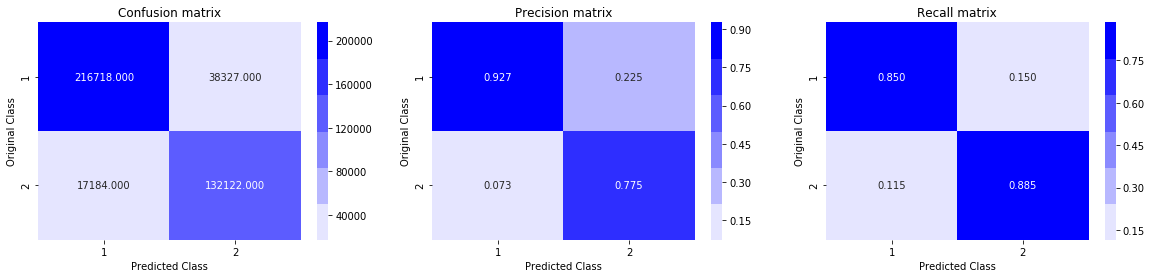

In [14]:
predict_y = clf.predict_proba(X_test)
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89    255045
           1       0.78      0.88      0.83    149306

   micro avg       0.86      0.86      0.86    404351
   macro avg       0.85      0.87      0.86    404351
weighted avg       0.87      0.86      0.86    404351

